In [91]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [92]:
# Load Dataset
file_path = "data/group5.xlsx"  # Use the relative path if the file is in the same directory
df = pd.read_excel(file_path)

In [93]:
# Inspect the Data
print(df.head())
print(df.info())
print(df.describe())

       id  Gender  Age       City Profession  Academic_Pressure  \
0  116782    Male   23     Bhopal    Student                  5   
1   28324    Male   33       Pune    Student                  3   
2   97624  Female   19     Nashik    Student                  4   
3  122053    Male   25    Chennai    Student                  3   
4   67402    Male   32  Bangalore    Student                  5   

   Work_Pressure  CGPA  Study_Satisfaction  Job_Satisfaction  \
0              0  8.74                   2                 0   
1              0  7.88                   4                 0   
2              0  5.45                   1                 0   
3              0  7.74                   1                 0   
4              0  9.96                   1                 0   

      Sleep_Duration Dietary_Habits    Degree  \
0          7-8 hours      Unhealthy      B.Ed   
1          5-6 hours       Moderate       PhD   
2  More than 8 hours      Unhealthy  Class 12   
3  More than 8 h

In [94]:
# Drop ID column since it’s not useful for prediction
df.drop(columns=['id'], inplace=True)

In [95]:
# Define the relevant columns for numerical, ordinal, and binary variables
numerical_columns = ['Work_Study_Hours']
ordinal_columns = ['Academic_Pressure', 'Study_Satisfaction', 'Financial_Stress', 'Sleep_Duration', 'Dietary_Habits']
binary_columns = ['Have_you_ever_had_suicidal_thoughts_', 'Family_History_of_Mental_Illness']
relevant_columns = numerical_columns + ordinal_columns + binary_columns

# Select features (X) and target (y) using only the relevant columns, and create a copy to avoid warnings
X = df[relevant_columns].copy()  # Use .copy() to ensure X is a new DataFrame
y = df['Depression']

# Handle missing values in the features
# For numerical columns, fill missing values with the median
for col in numerical_columns:
    X[col] = X[col].fillna(X[col].median())

# For categorical columns (ordinal and binary), fill missing values with the mode
for col in ordinal_columns + binary_columns:
    X[col] = X[col].fillna(X[col].mode()[0])

# Encode ordinal categorical variables with appropriate mappings
# Mapping for Sleep_Duration based on assumed order
sleep_duration_mapping = {'Less than 5 hours': 0, '5-6 hours': 1, '6-7 hours': 2, '7-8 hours': 3, 'More than 8 hours': 4}
X['Sleep_Duration'] = X['Sleep_Duration'].map(sleep_duration_mapping)

# Mapping for Dietary_Habits: Healthy (0), Middle (1), Unhealthy (2)
dietary_habits_mapping = {'Healthy': 0, 'Moderate': 1, 'Unhealthy': 2}
X['Dietary_Habits'] = X['Dietary_Habits'].map(dietary_habits_mapping)

# Ensure other ordinal variables are integers (they are already numerical: 0-5)
for col in ['Academic_Pressure', 'Study_Satisfaction', 'Financial_Stress']:
    X[col] = X[col].astype(int)

# Encode binary categorical variables: No (0), Yes (1)
for col in binary_columns:
    X[col] = X[col].map({'No': 0, 'Yes': 1})

In [96]:
# Split Data into Training & Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [97]:
# Train a Random Forest Model (Handles Class Imbalance if Needed)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Accuracy: 0.80425

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76      1666
           1       0.82      0.85      0.84      2334

    accuracy                           0.80      4000
   macro avg       0.80      0.79      0.80      4000
weighted avg       0.80      0.80      0.80      4000


Confusion Matrix:
 [[1229  437]
 [ 346 1988]]


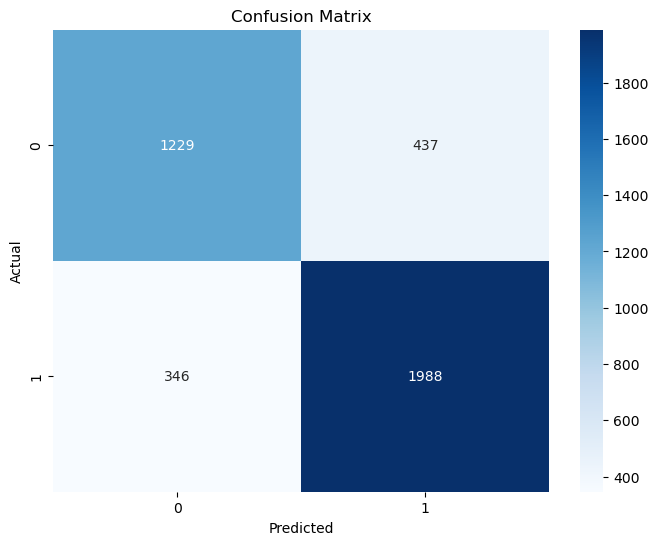

In [98]:
# Predict on Test Set
y_pred = rf_model.predict(X_test)

# Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [99]:
# Save the Random Forest model
joblib.dump(rf_model, 'model/random_forest_model.joblib')

# Save categorical options from the ordinal and binary columns
categorical_options = {col: df[col].unique().tolist() for col in ordinal_columns + binary_columns}
joblib.dump(categorical_options, 'model/categorical_options.joblib')

# Save the feature names
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'model/feature_names.joblib')

print("Model and related files saved successfully.")

Model and related files saved successfully.
